In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.optimize import minimize

In [2]:
#Define the ticker and the date range
ticker = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-10-31'

In [3]:
# Fetch the data for Tesla 
tsla_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Ensure the date index has a frequency and matches the length of the data
tsla_data = tsla_data.asfreq('B')

In [5]:
# Function to evaluate and refine SARIMA model
def evaluate_sarima_model(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit


In [6]:
# Function to plot the forecast with confidence intervals
def plot_forecast(data, forecast, conf_int, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Actual')
    plt.plot(forecast, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
# Evaluate and refine SARIMA model for TSLA
tsla_close_data = tsla_data['Close']
tsla_model_fit = evaluate_sarima_model(tsla_close_data, (1, 1, 1), (1, 1, 1, 12))


In [8]:
# Generate forecast for the next 12 months (365 days)
forecast_steps = 365
tsla_forecast = tsla_model_fit.get_forecast(steps=forecast_steps)
tsla_forecast_mean = tsla_forecast.predicted_mean
tsla_forecast_conf_int = tsla_forecast.conf_int()

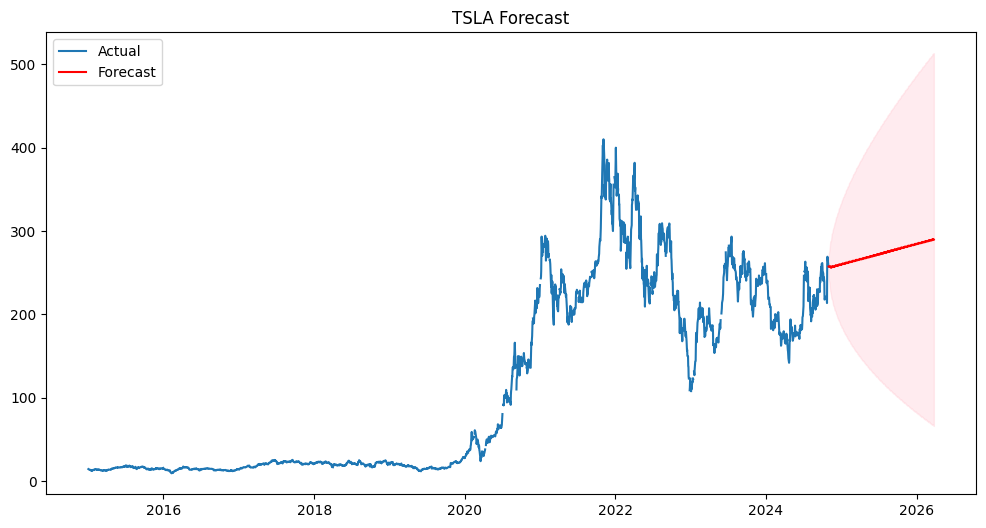

In [9]:
# Plot the forecast with historical data
plot_forecast(tsla_close_data, tsla_forecast_mean, tsla_forecast_conf_int, 'TSLA Forecast')

**Forecast Analysis and Insights:
Trend Analysis:
The forecast shows the expected trend of Tesla's stock prices over the next 12 months.
Look for long-term trends (upward, downward, or stable) and identify any patterns or anomalies in the forecast.

Volatility and Risk:
The confidence intervals show the range within which the future prices are expected to lie.
Discuss the level of uncertainty captured by the confidence intervals.
Highlight any periods where volatility is expected to increase.

Market Opportunities and Risks:
Based on the forecast, outline potential market opportunities (e.g., expected price increases) and risks (e.g., high volatility or expected declines)**

In [10]:
# Define the tickers and the date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

In [11]:
# Fetch the data for each ticker
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
# Ensure the date index has a frequency and matches the length of the data
for ticker in tickers:
    data[ticker] = data[ticker].asfreq('B')

In [13]:
# Function to evaluate and refine SARIMA model
def evaluate_sarima_model(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit

In [14]:
# Function to plot the forecast with confidence intervals
def plot_forecast(data, forecast, conf_int, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Actual')
    plt.plot(forecast, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()

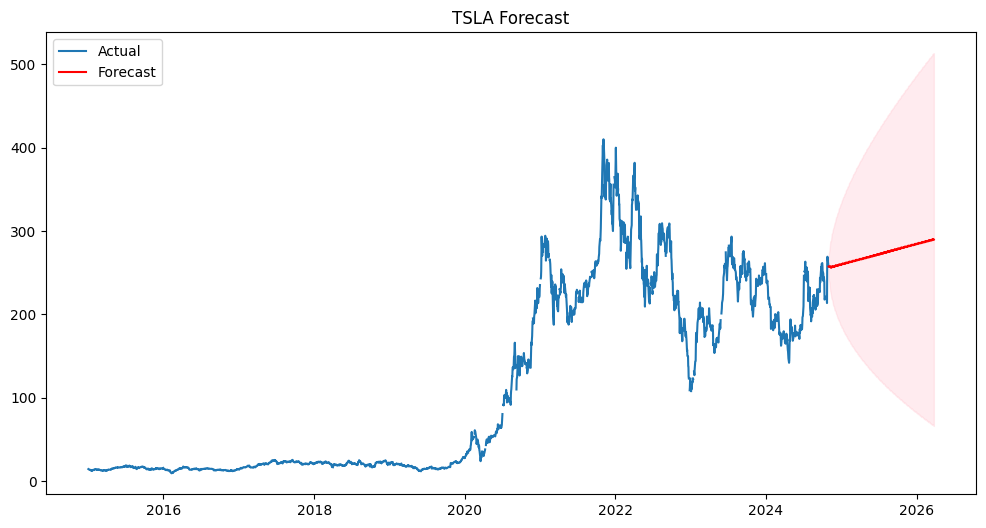

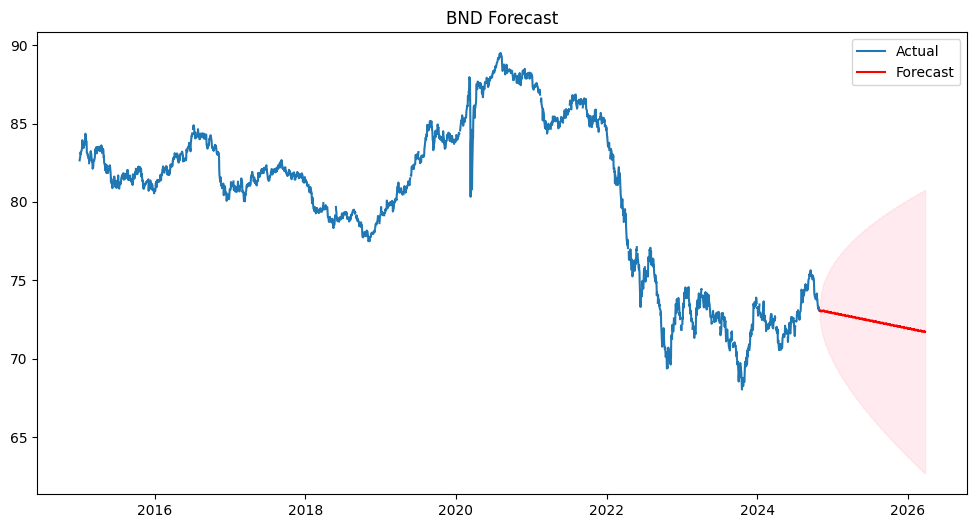

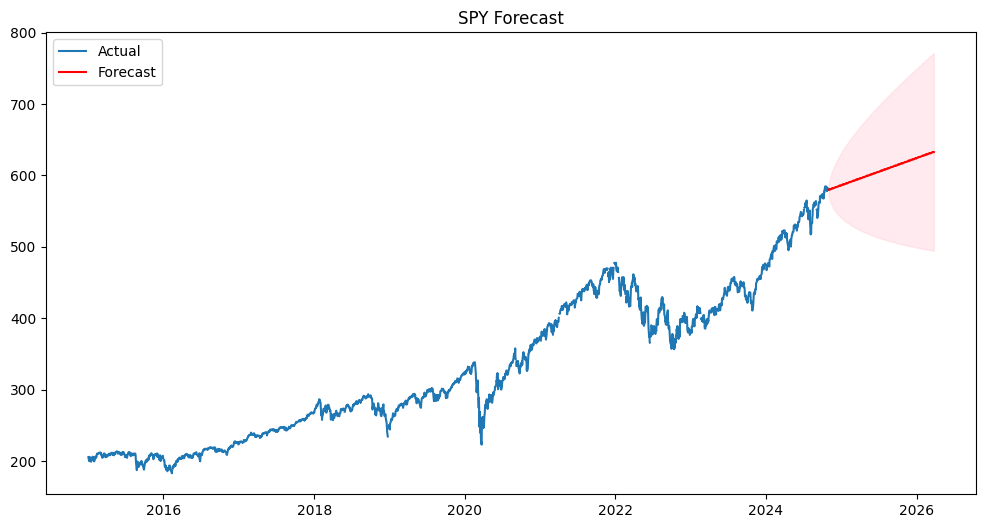

In [15]:
# Evaluate and refine SARIMA model for each ticker and generate forecasts
forecasts = {}
for ticker in tickers:
    close_data = data[ticker]['Close']
    model_fit = evaluate_sarima_model(close_data, (1, 1, 1), (1, 1, 1, 12))
    forecast_steps = 365
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    forecasts[ticker] = forecast_mean
    plot_forecast(close_data, forecast_mean, forecast_conf_int, f'{ticker} Forecast')

In [16]:
# Combine the data into one dataframe with columns TSLA, BND, and SPY
combined_data = pd.DataFrame({
    'TSLA': forecasts['TSLA'],
    'BND': forecasts['BND'],
    'SPY': forecasts['SPY']
})

In [17]:
# Compute the annual return by compounding the average daily returns for each asset
daily_returns = combined_data.pct_change().dropna()
annual_returns = daily_returns.mean() * 252

In [18]:
# Compute the covariance matrix of daily returns
cov_matrix = daily_returns.cov() * 252

In [19]:
# Define portfolio weights (initially equal weights)
weights = np.array([1/3, 1/3, 1/3])

In [20]:
# Compute the weighted average return and risk (volatility) of the portfolio
portfolio_return = np.dot(weights, annual_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [21]:
# Function to compute the Sharpe Ratio
def sharpe_ratio(weights):
    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

In [22]:
# Use optimization to find the weights that maximize the Sharpe Ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))
optimized_result = minimize(sharpe_ratio, weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [23]:
# Get the optimized weights
optimized_weights = optimized_result.x

In [24]:
# Compute the optimized portfolio return and volatility
optimized_portfolio_return = np.dot(optimized_weights, annual_returns)
optimized_portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))

In [25]:
# Calculate Value at Risk (VaR) for Tesla stock at a given confidence interval (e.g., 95%)
confidence_level = 0.95
var_tesla = np.percentile(daily_returns['TSLA'], (1 - confidence_level) * 100)

In [26]:
# Calculate the Sharpe Ratio for the optimized portfolio
optimized_sharpe_ratio = optimized_portfolio_return / optimized_portfolio_volatility

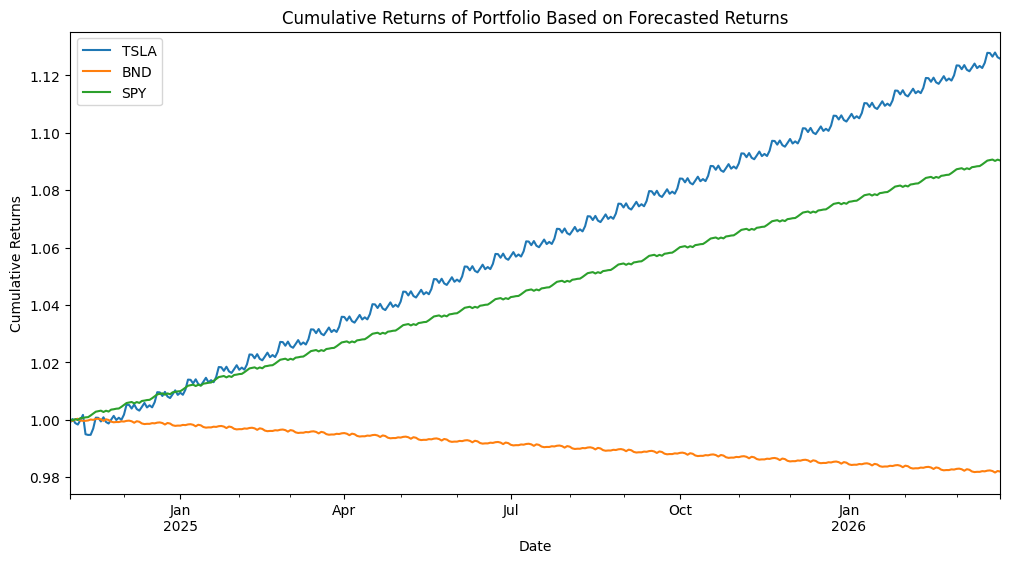

In [27]:
# Visualize how the portfolio would perform based on the forecasted returns
cumulative_returns = (daily_returns + 1).cumprod()
cumulative_returns.plot(figsize=(12, 6))
plt.title('Cumulative Returns of Portfolio Based on Forecasted Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

In [28]:
# Summarize the expected return, volatility, Sharpe Ratio, adjustments to asset allocation and reasons,
# and include cumulative return charts and risk-return analysis
print("Portfolio Optimization Summary:")
print(f"Expected Annual Return: {optimized_portfolio_return:.2f}")
print(f"Expected Volatility: {optimized_portfolio_volatility:.2f}")
print(f"Sharpe Ratio: {optimized_sharpe_ratio:.2f}")
print(f"Optimized Weights: {dict(zip(tickers, optimized_weights))}")
print(f"Value at Risk (VaR) for Tesla at {confidence_level*100}% confidence level: {var_tesla:.2f}")

Portfolio Optimization Summary:
Expected Annual Return: 0.06
Expected Volatility: 0.01
Sharpe Ratio: 11.01
Optimized Weights: {'TSLA': 0.029951903712929315, 'BND': 0.0, 'SPY': 0.9700480962872086}
Value at Risk (VaR) for Tesla at 95.0% confidence level: -0.00
